In [1]:
import os
import glob
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [3]:
def readBinaryData(n,SIZE,H,nbytes,BO='BE'):

    if nbytes==2:
        d = np.zeros((SIZE,SIZE,H),np.uint16)
    elif nbytes==1:
        d = np.zeros((SIZE,SIZE,H),np.uint8)
    else:
        print('Wrong number of bytes per voxel')
        return
    
    f=open(n,"rb")
    for i in range(0,H):
        for j in range(0,SIZE):
            for k in range(0,SIZE):
                byte = f.read(nbytes)
                if nbytes==2:
                    if BO =='BE':
                        a = 256*byte[0] + byte[1]
                    elif BO == 'LE':
                        a = byte[0] + 256*byte[1]
                        
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d


In [4]:
import h5py
import os

class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",
        bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied `outputPath` already "
                "exists and cannot be overwritten. Manually delete "
                "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),dtype="int")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
        labelSet = self.db.create_dataset("label_names",(len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [5]:
MAN_REG_DIR = '/home/user/Spine/Data/Regions/'
MAN_LES_DIR = '/home/user/Spine/Data/GroundTruth_PixelWiseOR/'
STIR_DIR = '/home/user/Spine/Data/STIR/'

nameMask = 'OR*.raw'

LEFT_BONE_TOP = 60
LEFT_BONE_BOTTOM = 70
RIGHT_BONE_TOP = 80
RIGHT_BONE_BOTTOM = 90
LEFT_MIDDLE_BONE_TOP = 100
LEFT_MIDDLE_BONE_BOTTOM = 110
RIGHT_MIDDLE_BONE_TOP = 120
RIGHT_MIDDLE_BONE_BOTTOM = 130

REFERENCE = 50
JOINT_LINE = 200

In [6]:

def descriptor(caseClass,R,C,S,data,mask,BOXXY=10,BOXZ=2):
    MIN = -5
    descriptor = []
    descriptor.append(caseClass)
    for s in range(-BOXZ,BOXZ+1):
        for r in range(-BOXXY,BOXXY):
            for c in range(-BOXXY,BOXXY):
                if R+r>=0 and R+r<data.shape[0] and C+c>=0 and C+c<data.shape[1] and S+s>=0 and S+s<data.shape[2]:
                    descriptor.append(data[R+r,C+c,S+s])
                else:
                    descriptor.append(MIN)
    return descriptor


In [7]:
lesions_list = glob.glob(MAN_LES_DIR + nameMask)
lesions_list.sort()
numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in lesions_list]
print(numbers)

man_regions_list = [f for f in glob.glob(MAN_REG_DIR+'Regions*.raw') if f.split('/')[-1].split('.')[0].split('_')[1] in numbers]
man_regions_list.sort()
man_numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in man_regions_list]
print(man_numbers)

stir_list = [f for f in glob.glob(STIR_DIR+'STIR*.raw') if f.split('/')[-1].split('.')[0].split('_')[1] in numbers]
stir_list.sort()
stir_numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in stir_list]
print(stir_numbers)


['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']
['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']
['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']


In [11]:
MARGIN = 10
FACTOR = 1
casesP = []
casesN = []

BOXXY = 10
BOXZ = 2

for l,s,m in zip(lesions_list,stir_list,man_regions_list):
    print(l)
    
    name_l = l.split('/')[-1].split('.')[0]
    _ , num_l,SIZE_l,_,H_l,B_l = name_l.split('_')
    lab = readBinaryData(l,int(SIZE_l),int(H_l),int(B_l))
                            
    name_s = s.split('/')[-1].split('.')[0]
    _ , num_s,SIZE_s,_,H_s,B_s,_ = name_s.split('_')
    stir = readBinaryData(s,int(SIZE_s),int(H_s),int(B_s))

    name_m = m.split('/')[-1].split('.')[0]
    _ , num_m,SIZE_m,_,H_m,B_m,_ = name_m.split('_')
    reg = readBinaryData(m,int(SIZE_m),int(H_m),int(B_m))

    SIZE = min(int(SIZE_l),int(SIZE_s),int(SIZE_m))
    
    if min(int(SIZE_l),int(SIZE_s),int(SIZE_m)) != max(int(SIZE_l),int(SIZE_s),int(SIZE_m)):
        print(name_l,' error')
        break
        
    H = min(int(H_l),int(H_s),int(H_m))
    stir = stir[:,:,:H]
    reg = reg[:,:,:H]
    lab = lab[:,:,:H]
    
    mean = np.mean(stir[reg==REFERENCE])#
    std = np.std(stir[reg==REFERENCE])
    stir = (stir-mean)/std
                         
    dilated = cv2.dilate(lab,None,iterations=MARGIN)
    
    pos = [(R,C,S) for R in range(0,SIZE) for C in range(0,SIZE) for S in range(0,H) if lab[R,C,S] and reg[R,C,S]>=LEFT_BONE_TOP and reg[R,C,S]!=JOINT_LINE]
    neg = [(R,C,S) for R in range(0,SIZE) for C in range(0,SIZE) for S in range(0,H) if dilated[R,C,S]==0 and reg[R,C,S]>=LEFT_BONE_TOP and reg[R,C,S]<=RIGHT_MIDDLE_BONE_BOTTOM]
    np.random.shuffle(neg)
    m = min(len(neg),len(pos)*FACTOR)
    neg = neg[:m]

    print(len(pos),len(neg))
    casesP.append(len(pos))
    casesN.append(len(neg))
    
    descriptors = []
    for case in pos:
        R,C,S = case
        descriptors.append(descriptor(1,int(R),int(C),int(S),stir,reg,BOXXY=BOXXY,BOXZ=BOXZ))
    for case in neg:
        R,C,S = case
        descriptors.append(descriptor(0,int(R),int(C),int(S),stir,reg,BOXXY=BOXXY,BOXZ=BOXZ))
    np.random.shuffle(descriptors)

    outputPath = 'features_' + num_l + '_.hdf5'
    writer = HDF5DatasetWriter((len(descriptors),2*BOXXY,2*BOXXY,2*BOXZ+1), outputPath)
    for desc in descriptors:
        label = desc[0]
        features = desc[1:]
        image = np.zeros((2*BOXZ+1,2*BOXXY,2*BOXXY),dtype = np.float64)
        np.copyto(image,np.reshape(features,(2*BOXZ+1,2*BOXXY,2*BOXXY)))
        image = np.swapaxes(image,0,1)
        image = np.swapaxes(image,1,2)
        writer.add([image], [label])
        del image
    writer.close()
    
    #break

f = open('cases.dat','w')
for cp,cn in zip(casesP,casesN):
    f.write(str(cp)+' ' + str(cn)+'\n')
f.close()    


/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_10_400_400_20_1.raw
285 285
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_11_400_400_23_1.raw
2115 2115
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_1_400_400_19_1.raw
32579 32579
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_24_400_400_20_1.raw
1204 1204
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_25_400_400_21_1.raw
947 947
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_26_400_400_18_1.raw
705 705
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_27_400_400_20_1.raw
2269 2269
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_28_400_400_18_1.raw
8529 8529
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_29_400_400_18_1.raw
2106 2106
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_2_400_400_18_1.raw
3421 3421
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_30_400_400_22_1.raw
1407 1407
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_31_400_400_24_1.raw
10625 10625
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_32_400_

72
0


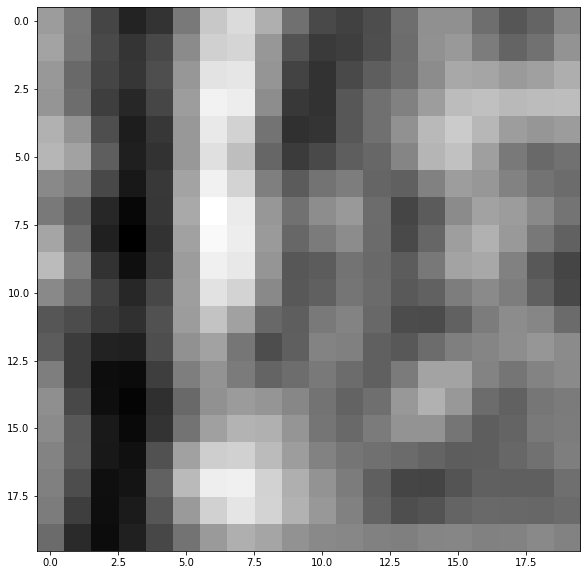

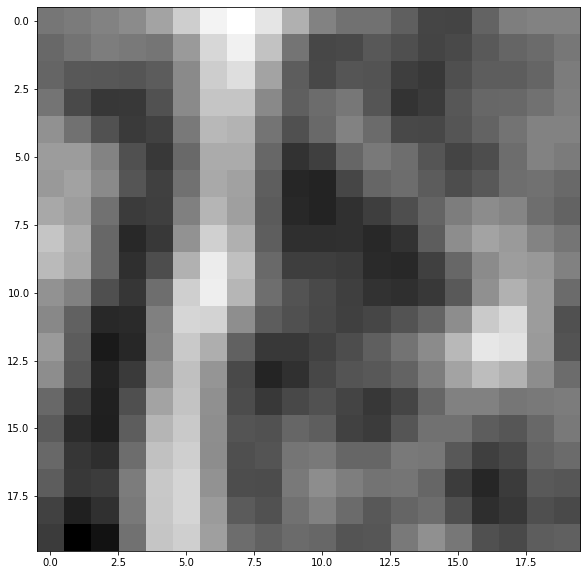

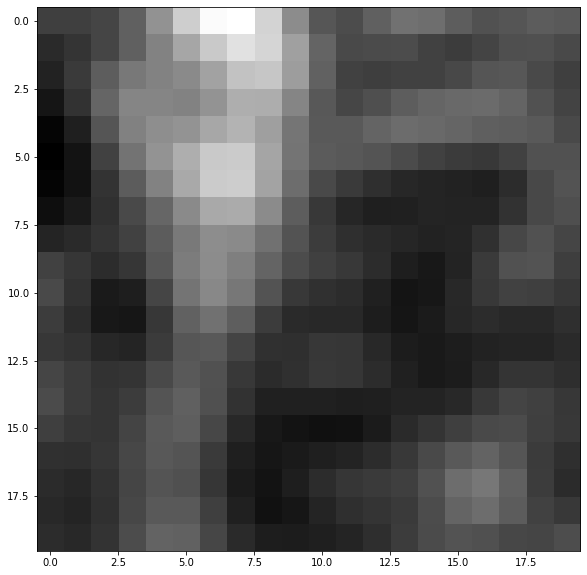

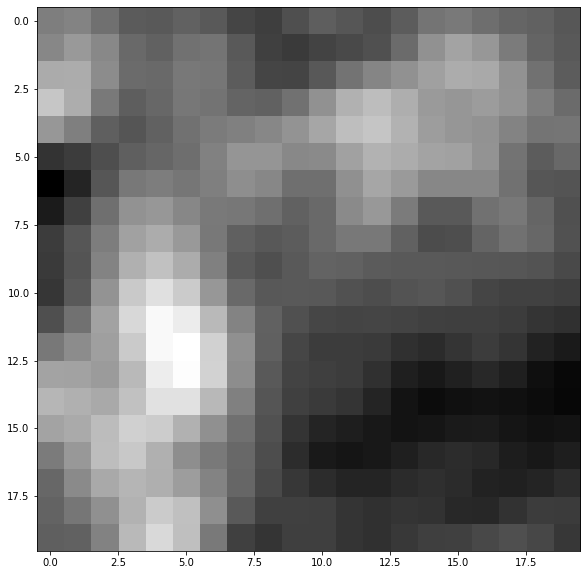

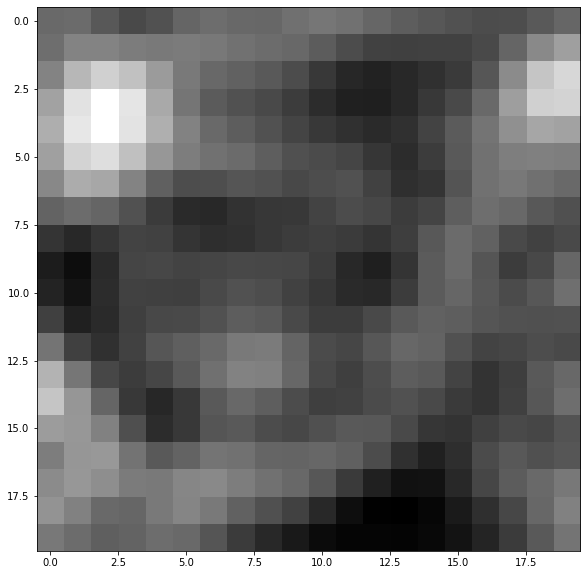

(20, 20, 5)


In [11]:
import h5py

dbPath = './Patches_OR/features_24_.hdf5'
db = h5py.File(dbPath,'r')
numImages = db["labels"].shape[0]
print(numImages)

for i in range(0, numImages):
    image = db["images"][i]
    print(db['labels'][i])
    for slice in range(image.shape[2]):
        showOpencvImage(image[:,:,slice])
    print(image.shape)
    break

In [8]:
MAN_REG_DIR = '/home/user/Spine/Data/Regions/'
MAN_LES_DIR = '/home/user/Spine/Data/GroundTruth_PixelWiseOR/'
STIR_DIR = '/home/user/Spine/Data/STIR/'

nameMask = 'OR*.raw'

LEFT_BONE_TOP = 60
LEFT_BONE_BOTTOM = 70
RIGHT_BONE_TOP = 80
RIGHT_BONE_BOTTOM = 90
LEFT_MIDDLE_BONE_TOP = 100
LEFT_MIDDLE_BONE_BOTTOM = 110
RIGHT_MIDDLE_BONE_TOP = 120
RIGHT_MIDDLE_BONE_BOTTOM = 130

REFERENCE = 50
JOINT_LINE = 200

MARGIN = 10
FACTOR = 1

BOXXY = 10
BOXZ = 2


lesions_list = glob.glob(MAN_LES_DIR + nameMask)
lesions_list.sort()
numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in lesions_list]
print(numbers)

man_regions_list = [f for f in glob.glob(MAN_REG_DIR+'Regions*.raw') if f.split('/')[-1].split('.')[0].split('_')[1] in numbers]
man_regions_list.sort()
man_numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in man_regions_list]
print(man_numbers)

stir_list = [f for f in glob.glob(STIR_DIR+'STIR*.raw') if f.split('/')[-1].split('.')[0].split('_')[1] in numbers]
stir_list.sort()
stir_numbers = [l.split('/')[-1].split('.')[0].split('_')[1] for l in stir_list]
print(stir_numbers)

descriptors = []

casesPath = '/home/user/Spine/Wyniki/Klasyfikacja/Patches_OR/cases.dat'
f=open(casesPath,'r')
sum = 0
while True:
    line = f.readline()
    if (len(line)==0):
        break
    cp,cn=map(int,line.split(' '))
    sum += cp+cn
f.close()
print(sum)

outputPath = 'AllFeaturesOR.hdf5'
writer = HDF5DatasetWriter((sum,2*BOXXY,2*BOXXY,2*BOXZ+1), outputPath)

for l,s,m in zip(lesions_list,stir_list,man_regions_list):
    print(l)
    
    name_l = l.split('/')[-1].split('.')[0]
    _ , num_l,SIZE_l,_,H_l,B_l = name_l.split('_')
    lab = readBinaryData(l,int(SIZE_l),int(H_l),int(B_l))
                            
    name_s = s.split('/')[-1].split('.')[0]
    _ , num_s,SIZE_s,_,H_s,B_s,_ = name_s.split('_')
    stir = readBinaryData(s,int(SIZE_s),int(H_s),int(B_s))

    name_m = m.split('/')[-1].split('.')[0]
    _ , num_m,SIZE_m,_,H_m,B_m,_ = name_m.split('_')
    reg = readBinaryData(m,int(SIZE_m),int(H_m),int(B_m))

    SIZE = min(int(SIZE_l),int(SIZE_s),int(SIZE_m))
    
    if min(int(SIZE_l),int(SIZE_s),int(SIZE_m)) != max(int(SIZE_l),int(SIZE_s),int(SIZE_m)):
        print(name_l,' error')
        break
        
    H = min(int(H_l),int(H_s),int(H_m))
    stir = stir[:,:,:H]
    reg = reg[:,:,:H]
    lab = lab[:,:,:H]
    
    mean = np.mean(stir[reg==REFERENCE])#
    std = np.std(stir[reg==REFERENCE])
    stir = (stir-mean)/std
                         
    dilated = cv2.dilate(lab,None,iterations=MARGIN)
    
    pos = [(R,C,S) for R in range(0,SIZE) for C in range(0,SIZE) for S in range(0,H) if lab[R,C,S] and reg[R,C,S]>=LEFT_BONE_TOP and reg[R,C,S]!=JOINT_LINE]
    neg = [(R,C,S) for R in range(0,SIZE) for C in range(0,SIZE) for S in range(0,H) if dilated[R,C,S]==0 and reg[R,C,S]>=LEFT_BONE_TOP and reg[R,C,S]<=RIGHT_MIDDLE_BONE_BOTTOM]
    np.random.shuffle(neg)
    m = min(len(neg),len(pos)*FACTOR)
    neg = neg[:m]

    print(len(pos),len(neg))
    
    for case in pos:
        R,C,S = case
        descriptors.append(descriptor(1,int(R),int(C),int(S),stir,reg,BOXXY=BOXXY,BOXZ=BOXZ))
    for case in neg:
        R,C,S = case
        descriptors.append(descriptor(0,int(R),int(C),int(S),stir,reg,BOXXY=BOXXY,BOXZ=BOXZ))

    del pos
    del neg

        
np.random.shuffle(descriptors)

for desc in descriptors:
    label = desc[0]
    features = desc[1:]
    image = np.zeros((2*BOXZ+1,2*BOXXY,2*BOXXY),dtype = np.float64)
    np.copyto(image,np.reshape(features,(2*BOXZ+1,2*BOXXY,2*BOXXY)))
    image = np.swapaxes(image,0,1)
    image = np.swapaxes(image,1,2)
    writer.add([image], [label])
    del image

del descriptors

writer.close()
    
    #break

  


['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']
['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']
['10', '11', '1', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '4', '5', '6', '7', '8', '9']
589917
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_10_400_400_20_1.raw
285 285
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_11_400_400_23_1.raw
2115 2115
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_1_400_400_19_1.raw
32579 32579
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_24_400_400_20_1.raw
1204 1204
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_25_400_400_21_1.raw
947 947
/home/user/Spine/Data/GroundTruth_PixelWiseOR/OR_26_400_400_18_1.raw
705 705
/home/us